In [9]:
#imports
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
pd.set_option('display.max_rows', 3000)

#Make sure that the SUMO_HOME environment variable is correctly set after installation:
SUMO_HOME = r"C:\Program Files (x86)\Eclipse\Sumo"

In [15]:
#Total length of lanes for the different networks
#These values are obtained manually from the nets, using SUMO-GUI and NETEDIT
net_length_net01 = 53920

net_length_net02_x2lanes = 2456.6 + 2516.6 + 2943.12 + 929.84 + 955.44 + 506.52 + 5373.72 + 4629.2 + 2854.32 + 1038.64 + 1503.96 + 507.32 + 504.52
net_length_net02_x1lanes = 504.32 + 979.04 + 475.72 + 490.52 + 754.98 + 965.24 + 1904.88 + 1851.68 + 978.04 + 964.24
net_length_net02 = net_length_net02_x2lanes + net_length_net02_x1lanes

net_length_net03_x2lanes = 21186.08
net_length_net03_x1lanes = 7263.8 + 5811.04
net_length_net03 = net_length_net03_x2lanes + net_length_net03_x1lanes

net_length_net04 = 58918.52


# Num of edges per network
num_edges_net01 = 220
num_edges_net02 = 192
num_edges_net03 = 196
num_edges_net04 = 242

net_lengths = [net_length_net01, net_length_net02, net_length_net03, net_length_net04]
net_num_edges = [num_edges_net01, num_edges_net02, num_edges_net03, num_edges_net04]

In [11]:
def create_df_for_traffic_fundamental_diagram(results_folder, net_length, num_edges):
    
    column_names = ['experiment', 'scale', 'lanes_length_m', 'flow', 'density', 'freq', 'edge_entered', 'edge_departed', 'edge_sampledSeconds']
    df_output = pd.DataFrame(columns = column_names)
    #iterate through the folder
    for file in os.listdir(results_folder + "/csv/"):
        if file.endswith("aadt_output_freq60s.csv"):
            output_csv_file =  str(results_folder + r"/csv/" + file)
            scale = float(output_csv_file.split('_')[-5])
            experiment = results_folder.split('/')[0]
            freq = 60
            #transform to pandas df
            df = pd.read_csv(output_csv_file, sep=";")
            #groupby
            df_g = df.groupby('interval_begin')[['edge_entered', 'edge_departed', 'edge_sampledSeconds']].apply(sum)
            #create variables of fundamental traffic diagram (#some refs: https://www.eclipse.org/lists/sumo-user/msg06970.html)
            df_g['scale'] = scale
            df_g['lanes_length_m'] = net_length
            df_g['flow'] = (((df_g.edge_entered + df_g.edge_departed)/freq)*3600)/num_edges #maybe freq here no TODO!!!!!
            df_g['density'] = (df_g.edge_sampledSeconds/freq)/(net_length/1000)
            df_g['experiment'] = experiment
            df_g['freq'] = freq
            #merge
            frames = [df_output, df_g]
            df_output = pd.concat(frames)
    
    return df_output

In [28]:
from scipy.interpolate import pchip
import statsmodels.api as sm
from operator import itemgetter

# COMBINING PCHIP AND LOWESS
def fit(x,y):
    
    pch = pchip(x, y)
    
    xx = np.linspace(x[0], x[-1], 1000)
    yy = pch(xx)
    
    lowess = sm.nonparametric.lowess(yy, xx, frac=0.2)
    
    x_lowess = lowess[:, 0]
    y_lowess = lowess[:, 1]
    return [x_lowess, y_lowess]


def estimate_critical_metrics(exp_df):
    
    exp_df_mod = exp_df.groupby('density').mean()
    exp_df_mod = exp_df_mod.sort_index()
    
    x = exp_df_mod.index
    y = exp_df_mod.flow

    [x2, y2] = fit(x, y)
    
    max_flow = max(y2)
    density_at_max_flow = x2[y2.argmax()]
    estimated_optimal_speed = (max_flow/density_at_max_flow) 
    return (max_flow, density_at_max_flow, estimated_optimal_speed, x2, y2)

def create_df_critical_metrics():
    
    column_names = ['net', 'meso_trial', 'lanes_length_m', 'max_flow', 'density_At_max_flow', 'optim_speed']
    df_compa = pd.DataFrame(columns = column_names)
    
    for key in dfs_meso:
        critical_metrics = estimate_critical_metrics(dfs_meso[key])
        df_compa.loc[len(df_compa.index)] = [key[0],
                                             key[1],
                                             dfs_meso[key].lanes_length_m.iloc[0], 
                                             critical_metrics[0], 
                                             critical_metrics[1], 
                                             critical_metrics[2]]
    
    return df_compa

In [41]:
nets = ['net01', 'net02', 'net03', 'net04']
meso_trials = ['trial01', 'trial02', 'trial03']

def getting_all_meso():
    dfs = dict() # each case's df will be saved in a dictionary
    for i in range(len(nets)):
        df_avg = pd.DataFrame() #create aggregated df for averaging the 2 meso trials per net
        # retrieving each meso trial
        for trial in meso_trials:
            results_folder = r"{}/data/results_meso_{}".format(nets[i], trial)
            net_length = net_lengths[i]
            num_edges = net_num_edges[i]
            # convert CSV file into dataframe
            df = create_df_for_traffic_fundamental_diagram(results_folder, net_length, num_edges)
            dfs[(nets[i],trial)] = df #saving it into the dictionary
            df_avg = pd.concat([df_avg,df]) #aggregating it into the agg. dataframe
        # when finishing to iterate through the 3 trials for each net, save the aggregated version into a different dictionary entry
        dfs[(nets[i],'AGG_4_AVG')] = df_avg
    return dfs
            
# def average_meso_trials(net, net_length, num_edges):
#     df_output = pd.DataFrame()
#     for trial in meso_trials:
#         results_folder = r"{}/data/results_meso_{}".format(net, trial)
#         df = create_df_for_traffic_fundamental_diagram(results_folder, net_length, num_edges)
#         frames = [df_output, df]
#         df_output = pd.concat(frames)        
#     return df_output

In [42]:
dfs_meso = getting_all_meso()

In [43]:
df_critical_metrics = create_df_critical_metrics()
df_critical_metrics

,net,meso_trial,lanes_length_m,max_flow,density_At_max_flow,optim_speed
0,net01,trial01,53920,1130.912050,46.452150,24.345742
1,net01,trial02,53920,1031.170653,39.610790,26.032570
2,net01,trial03,53920,862.342655,33.788157,25.522039
3,net01,AGG_4_AVG,53920,1061.714484,43.198255,24.577717
4,net02,trial01,36588.5,862.688930,29.703701,29.043147
5,net02,trial02,36588.5,648.383558,25.122296,25.809088
6,net02,trial03,36588.5,609.755098,22.059502,27.641381
7,net02,AGG_4_AVG,36588.5,693.240599,25.122296,27.594635
8,net03,trial01,34260.9,797.903041,28.385669,28.109362
9,net03,trial02,34260.9,501.769707,26.759244,18.751266


In [26]:
dfs_meso

,experiment,scale,lanes_length_m,flow,density,freq,edge_entered,edge_departed,edge_sampledSeconds
0.0,net01,0.05,53920,0.000000,0.000000,60,0.0,0.0,0.00
60.0,net01,0.05,53920,0.545455,0.005564,60,0.0,2.0,18.00
120.0,net01,0.05,53920,1.090909,0.037089,60,4.0,0.0,119.99
180.0,net01,0.05,53920,0.818182,0.037089,60,3.0,0.0,119.99
240.0,net01,0.05,53920,1.636364,0.052544,60,5.0,1.0,169.99
...,...,...,...,...,...,...,...,...,...
34920.0,net01,2.00,53920,236.727273,110.928811,60,856.0,12.0,358876.89
34980.0,net01,2.00,53920,8.181818,110.998603,60,26.0,4.0,359102.68
35040.0,net01,2.00,53920,1.090909,111.050321,60,0.0,4.0,359270.00
35100.0,net01,2.00,53920,265.090909,110.960006,60,878.0,94.0,358977.81


In [6]:
# df_tdf_002 = average_meso_trials(nets[0], net_length_net01, num_edges_net01)
# df_tdf_032 = average_meso_trials(nets[1], net_length_net02, num_edges_net02)
# df_tdf_052 = average_meso_trials(nets[2], net_length_net03, num_edges_net03)
# df_tdf_102 = average_meso_trials(nets[3], net_length_net04, num_edges_net04)

NameError: name 'results_folder_net01' is not defined

In [30]:
# Make directory for comparative fundamental diagrams
if not os.path.exists(r"charts"):
    os.makedirs(r"charts")

In [32]:
def plot_chart_1(trial):
    
    for key in dfs_meso:
        if key[1] == trial:
            if key[0] == 'net01': net01 = dfs_meso[key]
            elif key[0] == 'net02': net02 = dfs_meso[key]
            elif key[0] == 'net03': net03 = dfs_meso[key]
            elif key[0] == 'net04': net04 = dfs_meso[key]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,15), sharex=True, 
                           gridspec_kw={'hspace': 0, 'wspace': 0})

    fig.suptitle('Fundamental diagram of traffic flow', fontsize=16, y=0.9)
    col = ["#648FFF", "#DC267F", "#FE0000", "#FFB000"]
    # col = ["#9b7000", "#23d980", "#01ffff", "#004fff"] #INVERT

    ax.scatter(net01.density, net01['flow'], color=col[0], s=50, alpha=0.05)
    ax.scatter(net02.density, net02['flow'], color=col[1], s=50, alpha=0.05)
    ax.scatter(net03.density, net03['flow'], color=col[2], s=50, alpha=0.05)
    ax.scatter(net04.density, net04['flow'], color=col[3], s=50, alpha=0.05)

    ax.plot(estimate_critical_metrics(net01)[3], estimate_critical_metrics(net01)[4], color=col[0], label="net01 (existing situation)")
    ax.plot(estimate_critical_metrics(net02)[3], estimate_critical_metrics(net02)[4], color=col[1], label="net02 (Cerda's original grid)")
    ax.plot(estimate_critical_metrics(net03)[3], estimate_critical_metrics(net03)[4], color=col[2], label="net03 (Superblocks grid)")
    ax.plot(estimate_critical_metrics(net04)[3], estimate_critical_metrics(net04)[4], color=col[3], label="net04 (w/ diagonal avenue)")

    ax.set_ylabel('Flow (veh/h) - per edge of the network')
    ax.set_xlabel('Density (veh/km)')
    ax.legend(loc="upper right")
    ax.set_xlim(-5,140)
    ax.set_ylim(-50,1400)
    ax.axhline(y=0, xmin=-0.05, xmax=0.1, color=(0.25, 0.25, 0.25, 0.25))
    ax.axvline(x=0, ymin=-0.05, ymax=0.1, color=(0.25, 0.25, 0.25, 0.25))

    fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),
            orientation='portrait',
            transparent=True, bbox_inches='tight', pad_inches=0,
            frameon=None, metadata=None)
    
    return None

<ipython-input-32-93afcfe712ae>:35: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),
<ipython-input-32-93afcfe712ae>:35: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso_{}.png".format(trial),


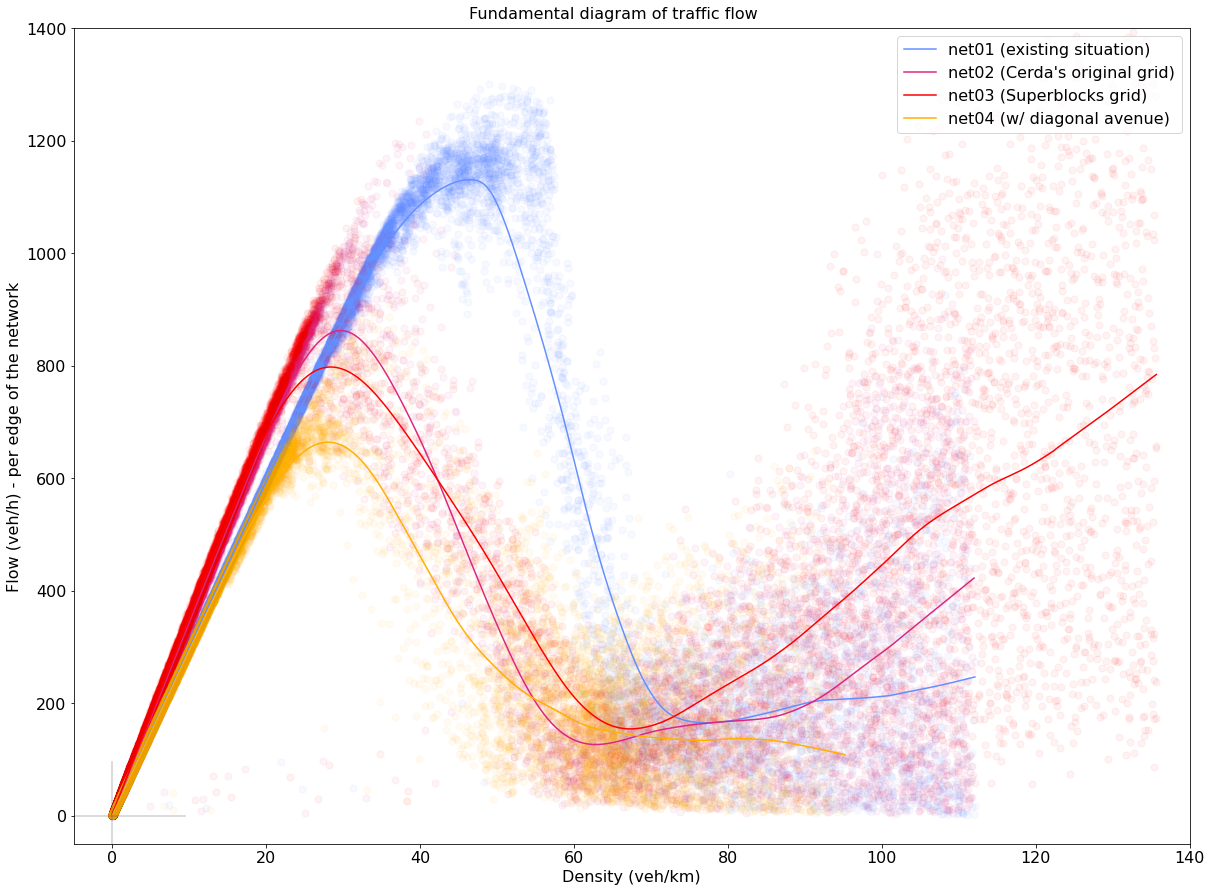

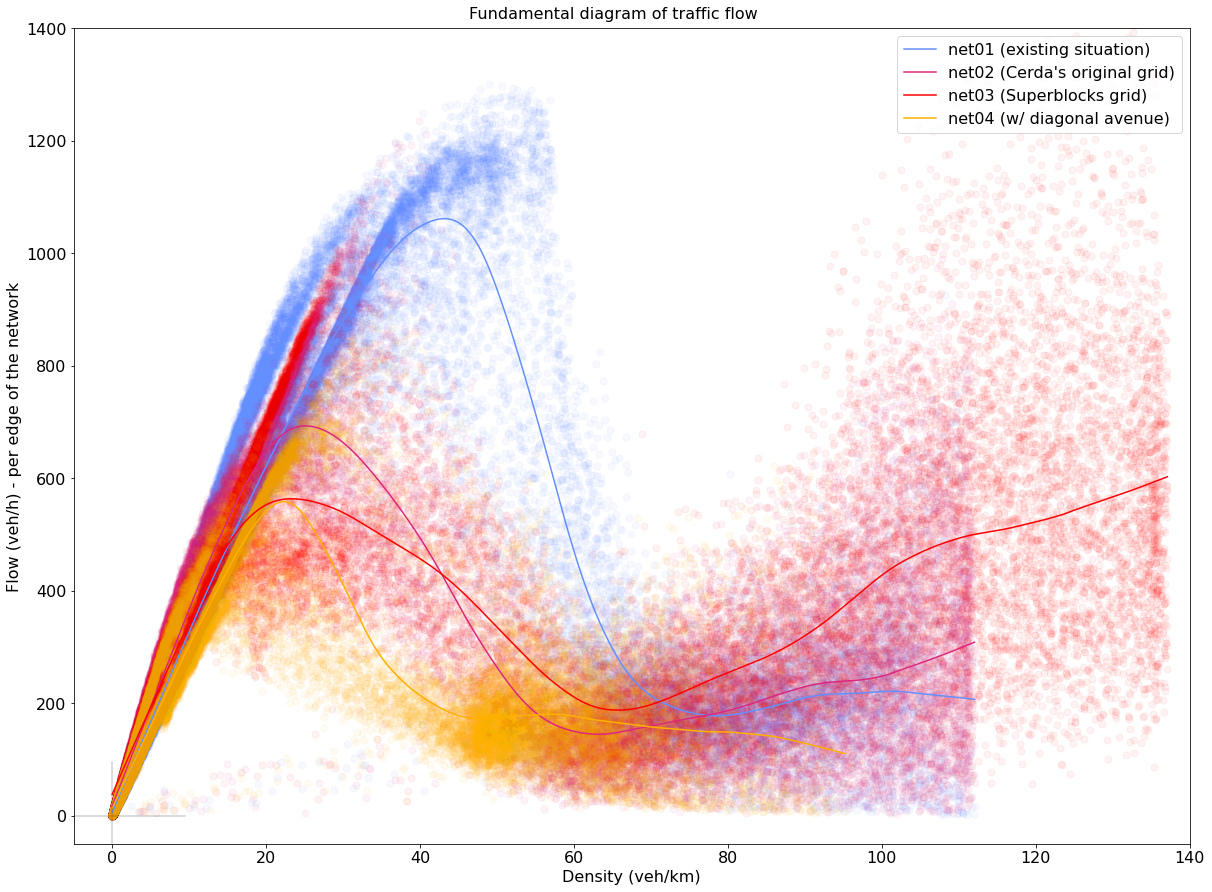

In [44]:
plot_chart_1("trial01")
plot_chart_1("AGG_4_AVG")


In [39]:
def plot_chart_2(trial):
    
    for key in dfs_meso:
        if key[1] == trial:
            if key[0] == 'net01': net01 = dfs_meso[key]
            elif key[0] == 'net02': net02 = dfs_meso[key]
            elif key[0] == 'net03': net03 = dfs_meso[key]
            elif key[0] == 'net04': net04 = dfs_meso[key]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15), sharex=True, 
                           gridspec_kw={'hspace': 0, 'wspace': 0})

    color_002 = cm.get_cmap('coolwarm')
    col = ["#648FFF", "#DC267F", "#FE0000", "#FFB000"]

    fig.suptitle('Fundamental diagram of traffic flow with scale', fontsize=16, y=0.9)

    ax.scatter(net01.density, net01['flow'], marker='o', s=100, alpha=0.1, color=color_002(net01.scale/2), label="net01 (existing situation). Sampling points")
    ax.scatter(net02.density, net02['flow'], marker='+', s=100, alpha=0.25, color=color_002(net02.scale/2), label="net02 (Cerda's original grid). Sampling points")
    ax.scatter(net03.density, net03['flow'], marker='^', s=100, alpha=0.25, color=color_002(net03.scale/2), label="net03 (Superblocks grid). Sampling points")
    ax.scatter(net04.density, net04['flow'], marker='x', s=100, alpha=0.1, color=color_002(net04.scale/2), label="net04 (w/ diagonal avenue). Sampling points")

    ax.plot(estimate_critical_metrics(net01)[3], estimate_critical_metrics(net01)[4], color=col[0], label="net01 (existing situation). Trend line")
    ax.plot(estimate_critical_metrics(net02)[3], estimate_critical_metrics(net02)[4], color=col[1], label="net02 (Cerda's original grid). Trend line")
    ax.plot(estimate_critical_metrics(net03)[3], estimate_critical_metrics(net03)[4], color=col[2], label="net03 (Superblocks grid). Trend line")
    ax.plot(estimate_critical_metrics(net04)[3], estimate_critical_metrics(net04)[4], color=col[3], label="net04 (w/ diagonal avenue). Trend line")

    ax.set_ylabel('Flow (veh/s)')
    ax.set_xlabel('Density (veh/km)')
    ax.legend(loc="upper right")
    ax.set_xlim(-5,140)
    ax.set_ylim(-50,1400)
    ax.axhline(y=0, xmin=-0.05, xmax=0.1, color=(0.25, 0.25, 0.25, 0.25))
    ax.axvline(x=0, ymin=-0.05, ymax=0.1, color=(0.25, 0.25, 0.25, 0.25))

    cNorm  = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=color_002)
    scalarMap.set_array([])
    cbar = fig.colorbar(scalarMap,ax=ax, aspect=40)
    cbar.set_label('scale of demand load (1 = current adjusted demand)', rotation=270,  labelpad=-70)

    fig.savefig("charts/MFD02_compar_01-02-03-04_meso_trial03.png", dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=True, bbox_inches='tight', pad_inches=0,
            frameon=None, metadata=None)
    
    return None

<ipython-input-39-99cf06692ceb>:42: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD02_compar_01-02-03-04_meso_trial03.png", dpi=None, facecolor='w', edgecolor='w',


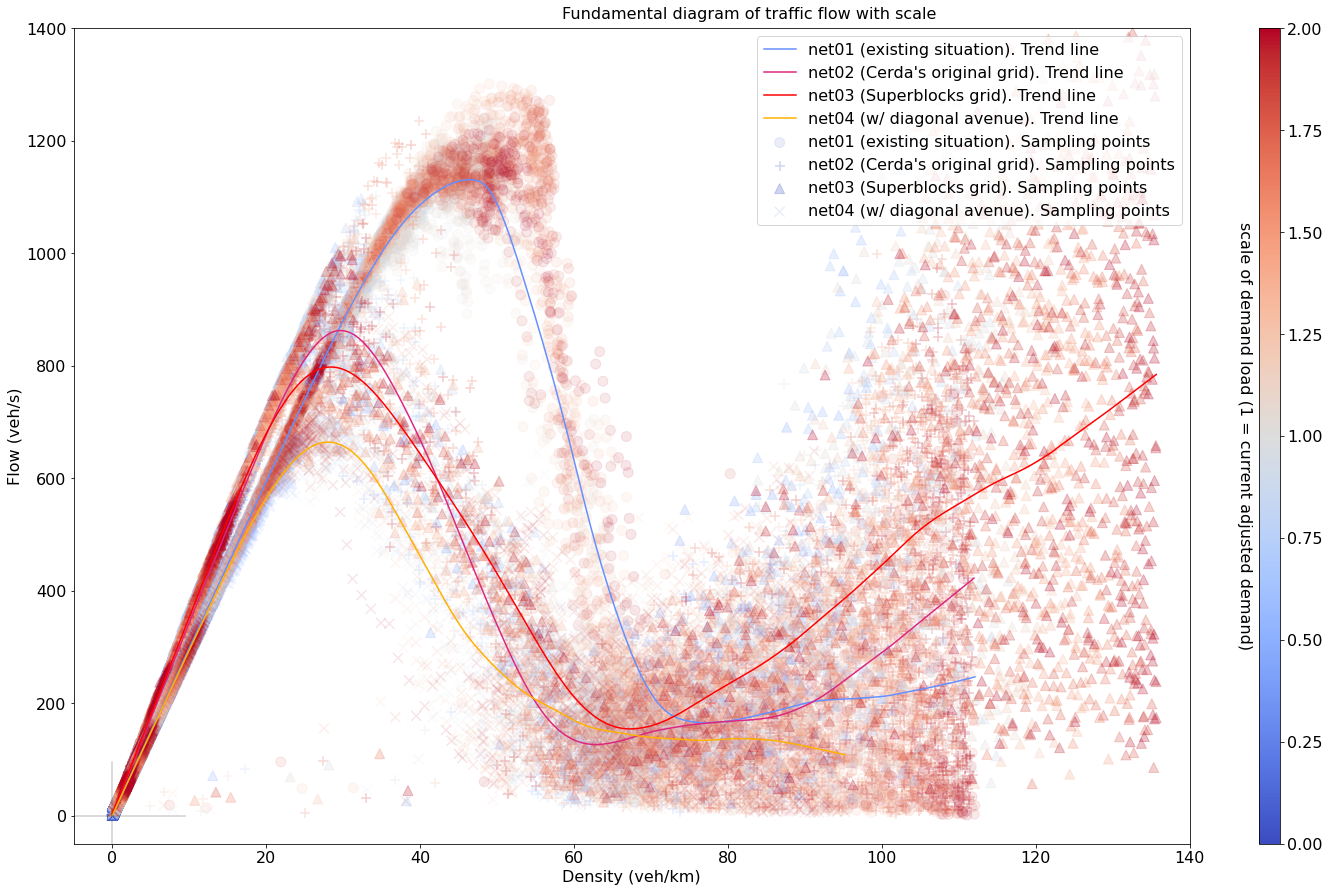

In [40]:
plot_chart_2("trial01")